In [ ]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from torchvision.io import read_image
import torch.nn.functional as F
import gc
import os
import glob
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from efficientnet_pytorch import EfficientNet
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

def convertir_csv_a_pt(csv_path, output_dir, batch_size=5000):
    os.makedirs(output_dir, exist_ok=True)
    df = pd.read_csv(csv_path)
    images, labels = [], []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Procesando {os.path.basename(csv_path)}"):
        ruta = row["ruta"]
        clase = int(row["clase"])

        # Leer y procesar imagen
        img = read_image(ruta).float() / 255.0
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)
        img = F.interpolate(img.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

        images.append(img)
        labels.append(clase)

        # Guardar batch
        if len(images) == batch_size or idx == len(df) - 1:
            batch_id = idx // batch_size
            torch.save({
                "images": torch.stack(images),
                "labels": torch.tensor(labels, dtype=torch.long)
            }, os.path.join(output_dir, f"batch_{batch_id}.pt"))

            print(f"✅ Guardado {os.path.basename(output_dir)}/batch_{batch_id}.pt")

            del images, labels
            images, labels = [], []
            torch.cuda.empty_cache()
            gc.collect()

# Configuración

train_csv = "D:/Mi unidad/TESIS/MURA-v1.1/train_multiclase_corr.csv"
valid_csv = "D:/Mi unidad/TESIS/MURA-v1.1/valid_multiclase_corr.csv"


def verificar_y_convertir(csv_path, output_dir):
    archivos = glob.glob(os.path.join(output_dir, "*.pt"))
    if len(archivos) > 0:
        print(f"✅ {output_dir} ya tiene {len(archivos)} archivos .pt. No se convierte de nuevo.")
    else:
        print(f"⚙️ Iniciando conversión de imágenes en {output_dir}...")
        convertir_csv_a_pt(csv_path, output_dir)

verificar_y_convertir(train_csv, "dataset_pt/train")
verificar_y_convertir(valid_csv, "dataset_pt/valid")

# ===============================
# Configuración
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"✅ Usando: {device}")

NUM_CLASSES = 14
BATCH_SIZE = 8
EPOCHS_FROZEN = 30
EPOCHS_UNFROZEN = 25
LR_FROZEN = 1e-3
LR_UNFROZEN = 1e-5
TOTAL_EPOCHS = EPOCHS_FROZEN + EPOCHS_UNFROZEN

checkpoint_path = "checkpoint_efficientnet.pth"

# ===============================
# Cargar modelo EfficientNetB4
# ===============================
model = EfficientNet.from_pretrained("efficientnet-b4")
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False
for param in model._fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=LR_FROZEN)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.2)
scaler = torch.amp.GradScaler()


# ===============================
# Cargar pesos de clase
# ===============================
train_csv = "D:/Mi unidad/TESIS/MURA-v1.1/train_multiclase_corr.csv"
y_train = pd.read_csv(train_csv)["clase"].values
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# ===============================
# Entrenamiento por bloques .pt
# ===============================
train_batches = sorted(glob.glob("dataset_pt/train/*.pt"))
valid_batches = sorted(glob.glob("dataset_pt/valid/*.pt"))

start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scaler.load_state_dict(checkpoint["scaler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Checkpoint cargado. Retomando desde época {start_epoch}")
else:
    print("No se encontró checkpoint. Entrenamiento desde cero.")

gc.collect()
torch.cuda.empty_cache()
for epoch in range(start_epoch, TOTAL_EPOCHS):
    print(f" Época {epoch+1}/{TOTAL_EPOCHS}")

    #  Fase 2: fine-tuning completo
    if epoch == EPOCHS_FROZEN:
        print(" Cambiando a fase 2: fine-tuning completo")
        for param in model.parameters():
            param.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=LR_UNFROZEN)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.2)

    model.train()
    total, correct, loss_acum = 0, 0, 0

    for pt_file in train_batches:
        data = torch.load(pt_file)
        X = data["images"]
        y = data["labels"]
        loader = DataLoader(TensorDataset(X, y), batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)

        loop = tqdm(loader, desc=f"Entrenando {os.path.basename(pt_file)}")
        for images, labels in loop:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loss_acum += loss.item()
            loop.set_postfix(loss=loss_acum / len(loader), acc=correct / total)

        del X, y, data, loader
        torch.cuda.empty_cache()
        gc.collect()

    # ===============================
    # Validación
    # ===============================
    model.eval()
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for pt_file in valid_batches:
            data = torch.load(pt_file)
            X = data["images"]
            y = data["labels"]
            val_loader = DataLoader(TensorDataset(X, y), batch_size=BATCH_SIZE, shuffle=False)

            for images, labels in val_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                del images, labels, outputs, preds
                torch.cuda.empty_cache()
                gc.collect()

            del data, val_loader, X, y



    val_acc = val_correct / val_total
    print(f" Precisión validación: {val_acc:.4f}")

    torch.save({
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scaler_state_dict": scaler.state_dict()
    }, checkpoint_path)
    print(f"Checkpoint guardado (época {epoch+1})")


# ===============================
# Guardar modelo
# ===============================
torch.save(model.state_dict(), "efficientnet_final.pth")
print("✅ Modelo guardado como efficientnet_final.pth")


✅ dataset_pt/train ya tiene 8 archivos .pt. No se convierte de nuevo.
✅ dataset_pt/valid ya tiene 1 archivos .pt. No se convierte de nuevo.
✅ Usando: cuda
Loaded pretrained weights for efficientnet-b4
Checkpoint cargado. Retomando desde época 33
 Época 34/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:10<00:00, 20.64it/s, acc=0.222, loss=82.8]


 Precisión validación: 0.2330
Checkpoint guardado (época 34)
 Época 35/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:10<00:00, 20.69it/s, acc=0.282, loss=56.8]


 Precisión validación: 0.2549
Checkpoint guardado (época 35)
 Época 36/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:11<00:00, 20.19it/s, acc=0.348, loss=43.2]


 Precisión validación: 0.2612
Checkpoint guardado (época 36)
 Época 37/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:11<00:00, 20.08it/s, acc=0.399, loss=36.4]


 Precisión validación: 0.2587
Checkpoint guardado (época 37)
 Época 38/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:10<00:00, 20.72it/s, acc=0.433, loss=32.7]


 Precisión validación: 0.2637
Checkpoint guardado (época 38)
 Época 39/55


Entrenando batch_7.pt: 100%|████████████████████████████████████| 226/226 [00:10<00:00, 20.60it/s, acc=0.46, loss=30.5]


 Precisión validación: 0.2671
Checkpoint guardado (época 39)
 Época 40/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:10<00:00, 20.85it/s, acc=0.479, loss=29.2]


 Precisión validación: 0.2715
Checkpoint guardado (época 40)
 Época 41/55


Entrenando batch_7.pt: 100%|█████████████████████████████████████| 226/226 [00:10<00:00, 20.62it/s, acc=0.492, loss=28]


 Precisión validación: 0.2790
Checkpoint guardado (época 41)
 Época 42/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:11<00:00, 20.17it/s, acc=0.499, loss=27.5]


 Precisión validación: 0.2912
Checkpoint guardado (época 42)
 Época 43/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:11<00:00, 20.03it/s, acc=0.502, loss=27.1]


 Precisión validación: 0.2959
Checkpoint guardado (época 43)
 Época 44/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:11<00:00, 20.44it/s, acc=0.514, loss=26.4]


 Precisión validación: 0.3000
Checkpoint guardado (época 44)
 Época 45/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:10<00:00, 20.59it/s, acc=0.521, loss=26.1]


 Precisión validación: 0.3043
Checkpoint guardado (época 45)
 Época 46/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:11<00:00, 20.42it/s, acc=0.525, loss=25.7]


 Precisión validación: 0.3112
Checkpoint guardado (época 46)
 Época 47/55


Entrenando batch_7.pt: 100%|████████████████████████████████████| 226/226 [00:11<00:00, 20.44it/s, acc=0.52, loss=25.9]


 Precisión validación: 0.3178
Checkpoint guardado (época 47)
 Época 48/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:11<00:00, 20.49it/s, acc=0.526, loss=25.4]


 Precisión validación: 0.3222
Checkpoint guardado (época 48)
 Época 49/55


Entrenando batch_7.pt: 100%|████████████████████████████████████| 226/226 [00:11<00:00, 20.19it/s, acc=0.53, loss=25.4]


 Precisión validación: 0.3259
Checkpoint guardado (época 49)
 Época 50/55


Entrenando batch_7.pt: 100%|████████████████████████████████████| 226/226 [00:11<00:00, 20.54it/s, acc=0.53, loss=25.1]


 Precisión validación: 0.3300
Checkpoint guardado (época 50)
 Época 51/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:10<00:00, 20.60it/s, acc=0.539, loss=24.8]


 Precisión validación: 0.3275
Checkpoint guardado (época 51)
 Época 52/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:10<00:00, 20.72it/s, acc=0.539, loss=24.7]


 Precisión validación: 0.3328
Checkpoint guardado (época 52)
 Época 53/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:11<00:00, 20.47it/s, acc=0.545, loss=24.5]


 Precisión validación: 0.3297
Checkpoint guardado (época 53)
 Época 54/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:11<00:00, 19.47it/s, acc=0.541, loss=24.5]


 Precisión validación: 0.3344
Checkpoint guardado (época 54)
 Época 55/55


Entrenando batch_7.pt: 100%|███████████████████████████████████| 226/226 [00:11<00:00, 19.83it/s, acc=0.547, loss=24.1]


 Precisión validación: 0.3322
Checkpoint guardado (época 55)
✅ Modelo guardado como efficientnet_final.pth


**PREDICCIONES**

In [ ]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for pt_file in valid_batches:
        data = torch.load(pt_file)
        X = data["images"]
        y = data["labels"]
        val_loader = DataLoader(TensorDataset(X, y), batch_size=BATCH_SIZE, shuffle=False)

        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        del data, X, y, val_loader
        torch.cuda.empty_cache()
        gc.collect()

# ===============================
# Reporte de clasificación
# ===============================
target_names = [f"Clase {i}" for i in range(NUM_CLASSES)]
reporte = classification_report(all_labels, all_preds, target_names=target_names, digits=3)
print("📊 Reporte de Clasificación:\n")
print(reporte)


📊 Reporte de Clasificación:

              precision    recall  f1-score   support

     Clase 0      0.457     0.298     0.361       285
     Clase 1      0.143     0.022     0.037       278
     Clase 2      0.429     0.051     0.091       235
     Clase 3      0.378     0.430     0.402       230
     Clase 4      0.500     0.313     0.385       214
     Clase 5      0.721     0.324     0.447       247
     Clase 6      0.109     0.893     0.194       150
     Clase 7      0.331     0.298     0.314       151
     Clase 8      0.641     0.461     0.536       271
     Clase 9      0.602     0.344     0.438       189
    Clase 10      1.000     0.007     0.013       148
    Clase 11      0.500     0.007     0.014       140
    Clase 12      0.432     0.511     0.468       364
    Clase 13      0.479     0.529     0.502       295

    accuracy                          0.332      3197
   macro avg      0.480     0.321     0.300      3197
weighted avg      0.473     0.332     0.328      31

In [ ]:
import os
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import gc

# Crear carpeta de salida si no existe
os.makedirs("roc_por_clase", exist_ok=True)

# Convertir etiquetas a one-hot
y_true = label_binarize(np.array(all_labels), classes=list(range(NUM_CLASSES)))
y_score = np.array(all_probs)

# ROC y AUC por clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Crear gráfico individual para la clase i
    plt.figure(figsize=(6, 5))
    plt.plot(fpr[i], tpr[i], color='blue', lw=2, label=f"AUC = {roc_auc[i]:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Falsos Positivos")
    plt.ylabel("Verdaderos Positivos")
    plt.title(f"Curva ROC - Clase {i}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()

    # Guardar la figura
    ruta_figura = f"roc_por_clase/roc_clase_{i}.png"
    plt.savefig(ruta_figura)
    plt.close()
    print(f"✅ Curva ROC guardada para Clase {i} → {ruta_figura}")

gc.collect()


✅ Curva ROC guardada para Clase 0 → roc_por_clase/roc_clase_0.png
✅ Curva ROC guardada para Clase 1 → roc_por_clase/roc_clase_1.png
✅ Curva ROC guardada para Clase 2 → roc_por_clase/roc_clase_2.png
✅ Curva ROC guardada para Clase 3 → roc_por_clase/roc_clase_3.png
✅ Curva ROC guardada para Clase 4 → roc_por_clase/roc_clase_4.png
✅ Curva ROC guardada para Clase 5 → roc_por_clase/roc_clase_5.png
✅ Curva ROC guardada para Clase 6 → roc_por_clase/roc_clase_6.png
✅ Curva ROC guardada para Clase 7 → roc_por_clase/roc_clase_7.png
✅ Curva ROC guardada para Clase 8 → roc_por_clase/roc_clase_8.png
✅ Curva ROC guardada para Clase 9 → roc_por_clase/roc_clase_9.png
✅ Curva ROC guardada para Clase 10 → roc_por_clase/roc_clase_10.png
✅ Curva ROC guardada para Clase 11 → roc_por_clase/roc_clase_11.png
✅ Curva ROC guardada para Clase 12 → roc_por_clase/roc_clase_12.png
✅ Curva ROC guardada para Clase 13 → roc_por_clase/roc_clase_13.png


6135

C:\Users\andre\AppData\Local\Temp\ipykernel_13288\4222074219.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\andre\AppData\Local\Temp\ipykernel_13288\4222074219.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("matriz_confusion.png")
C:\Users\andre\miniconda3\envs\pytorch-gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


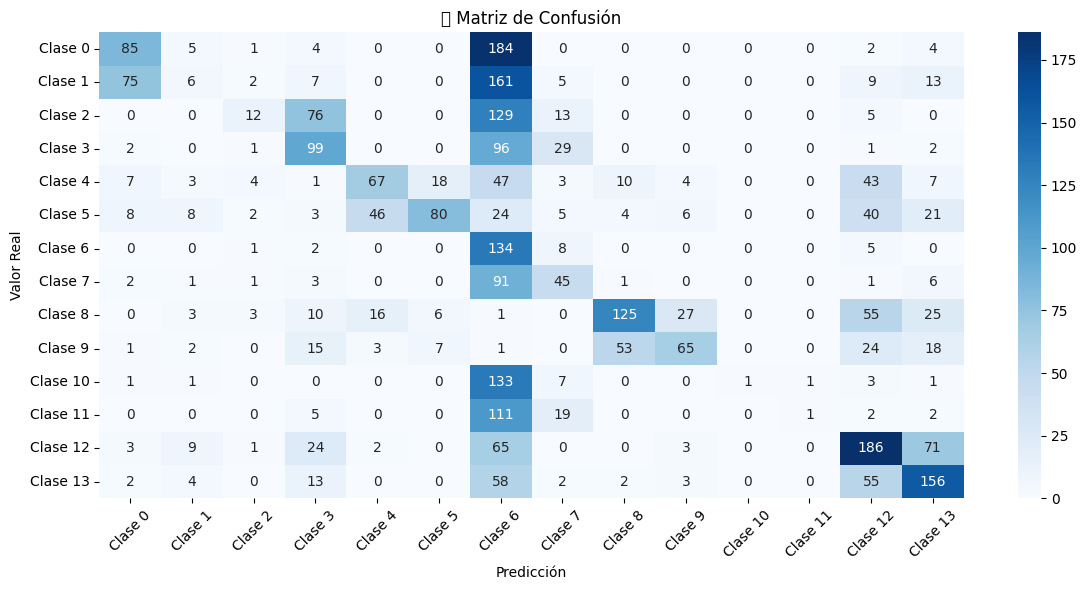

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Asegúrate de tener estas listas ya preparadas:
# all_labels → etiquetas verdaderas (enteros)
# all_preds  → predicciones del modelo (enteros)

# ===============================
# Matriz de confusión
# ===============================
cm = confusion_matrix(all_labels, all_preds)
labels = [f"Clase {i}" for i in range(NUM_CLASSES)]

plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("📊 Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("matriz_confusion.png")
plt.show()
